In [6]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"

In [7]:
import sys
import ast
import mysql.connector
import numpy as np
import pandas as pd
import torch
import hdbscan
from torch import nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from stl import mesh as np_mesh  # Import numpy-stl
from scipy.spatial.distance import cdist
from collections import defaultdict
from joblib import Parallel, delayed
import gc
import psutil
import shutil
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
class Proj_DBhelper:
    def __init__(self, data_base):
        try:
            self.conn = mysql.connector.connect(host="localhost", user="root", password="", database=data_base)
            self.mycursor = self.conn.cursor()
        except:
            print("some has occured")
            sys.exit(0)
        else:
            print("Database is connected")

    def create_table(self, table_name):
        try:
            create_table_query = f"""
                                    CREATE TABLE IF NOT EXISTS {table_name} (
                                        id INT(11) AUTO_INCREMENT PRIMARY KEY,
                                        file_name VARCHAR(255) NULL,
                                        proj_feature_vector VARCHAR(255) NULL,
                                        cluster_label INT(11) NULL
                                    );"""
            self.mycursor.execute(create_table_query)
            self.conn.commit()
        except:
            print("Table has not been created")
            sys.exit(0)
        else:
            print("Table is ready.")

    def register(self, stl_file, cluster_label = -1):
        try:
            insert_query = """INSERT INTO `stl_5000` (`file_name`, `cluster_label`) VALUES (%s, %s);"""
            self.mycursor.execute(insert_query, (stl_file, cluster_label))
            self.conn.commit()
        except:
            print(f"{stl_file} could not entered in the database")
        else:
            print(f"{stl_file} is entered in the database")
        
        
    def update_cluster_label(self, stl_file, cluster_label):
        try:
            update_query = """UPDATE `stl_5000` SET `cluster_label` = %s WHERE `stl_5000`.`file_name` = %s;"""
            self.mycursor.execute(update_query, (cluster_label, stl_file))
            self.conn.commit()
        except:
            print(f"could not able to update for the {stl_file}")
        else:
            print(f"updatation of label is sucessfull for the {stl_file}")
        
        
    def update_feature_vector(self, stl_file, proj_feature):
        try:
            update_query = """UPDATE `stl_5000` SET `proj_feature_vector` = %s WHERE `stl_5000`.`file_name` = %s;"""
            self.mycursor.execute(update_query, (proj_feature, stl_file))
            self.conn.commit()
        except:
            print(f"The vectors could not enter in the database")
        else:
            print(f"The vectors are entered in the database")
        
    def search_feature_vector(self, stl_file):
        try:
            self.mycursor.execute("""SELECT proj_feature_vector FROM stl_5000
                                WHERE file_name LIKE '{}'""".format(stl_file))
            data = self.mycursor.fetchone()
            return data[0]
        except:
            return None
        
    def search_feature_vector_through_id(self, id_number):
        try:
            self.mycursor.execute("""SELECT file_name, proj_feature_vector FROM stl_5000
                                WHERE id LIKE '{}'""".format(id_number))
            data = self.mycursor.fetchone()
            return data[0], data[1]
        except:
            return None, None
        
    def search_cluster_label_files(self, cluster_label):
        try:
            search_query = """SELECT `file_name` FROM `stl_5000` WHERE `cluster_label` LIKE %s"""
            self.mycursor.execute(search_query, (cluster_label,))
            data = self.mycursor.fetchall()
            return data, True
        except:
            return None, False
    
    def search_corresponding_label(self, stl_file):
        try:
            search_query = """SELECT `cluster_label` FROM `stl_5000` WHERE `file_name` LIKE %s"""
            self.mycursor.execute(search_query, (stl_file,))
            data = self.mycursor.fetchone()
            return data[0]
        except:
            return None
        
    def search_max_cluster_label(self):
        try:
            query = """SELECT MAX(cluster_label) FROM stl_5000"""
            self.mycursor.execute(query)
            max_value = self.mycursor.fetchone()
            return max_value[0]
        except:
            return -1
        
    def search_total_files(self):
        try:
            query = """SELECT MAX(id) FROM stl_5000"""
            self.mycursor.execute(query)
            max_value = self.mycursor.fetchone()
            return max_value[0]
        except:
            return 0
    

In [23]:
class Proj_Feature_Data_Base:
    def __init__(self, data_base):                               
        self.db = Proj_DBhelper(data_base)   #connect to the database

    def table_creation(self, table_name):
        self.db.create_table(table_name)    #create table
        
    def send_files_to_db(self, stl_files):
        for file in stl_files:
            self.db.register(file)
                
    def send_labels_to_db(self, stl_file, cluster_label):
        self.db.update_cluster_label(stl_file, cluster_label)

    def send_feature_vector_to_db(self, stl_file, proj_vector):
        self.db.update_feature_vector(stl_file, proj_vector)
        
    def find_feature_vector(self, stl_file):
        vector_file_name = self.db.search_feature_vector(stl_file)
        if vector_file_name:
            return vector_file_name, True
        else:
            return None, False
        
    def find_feature_vector_through_id(self, id_number):
        file_name, vector_file_name = self.db.search_feature_vector_through_id(id_number)
        if vector_file_name:
            return file_name, vector_file_name, True
        else:
            return file_name, None, False
        
    def find_files(self, cluster_label):
        data, flag = self.db.search_cluster_label_files(cluster_label)
        if(flag):
            if(len(data) > 0):
                return data
        return None

    def find_label(self, stl_file):
        data = self.db.search_corresponding_label(stl_file)
        if data:
            return data
        else:
            return None
    
    def maximum_cluster_label(self):
        number = self.db.search_max_cluster_label()
        return number
    
    def count_files(self):
        number = self.db.search_total_files()
        return number

    def data_distribution(self):
        length = self.maximum_cluster_label()
        dictionary = {}
        for i in range(length+1):
            num_files, flag = self.db.search_cluster_label_files(i)
            if(flag):
                if(len(num_files) > 0):
                    dictionary[i] = len(num_files)
            else:
                dictionary[i] = 0
            

        clusters = list(dictionary.keys())
        values = list(dictionary.values())
        
        fig = plt.figure(figsize = (20, 10))

        # creating the bar plot
        plt.bar(clusters, values, color ='maroon', width = 0.8)

        plt.xlabel("Cluster labels")
        plt.ylabel("No. of files of corresponding labels")
        plt.title("clusters vs no. of files")
        plt.show()

In [24]:
s1 = Proj_Feature_Data_Base("aws_database_dummy")

Database is connected


In [21]:
s1.maximum_cluster_label()

2813

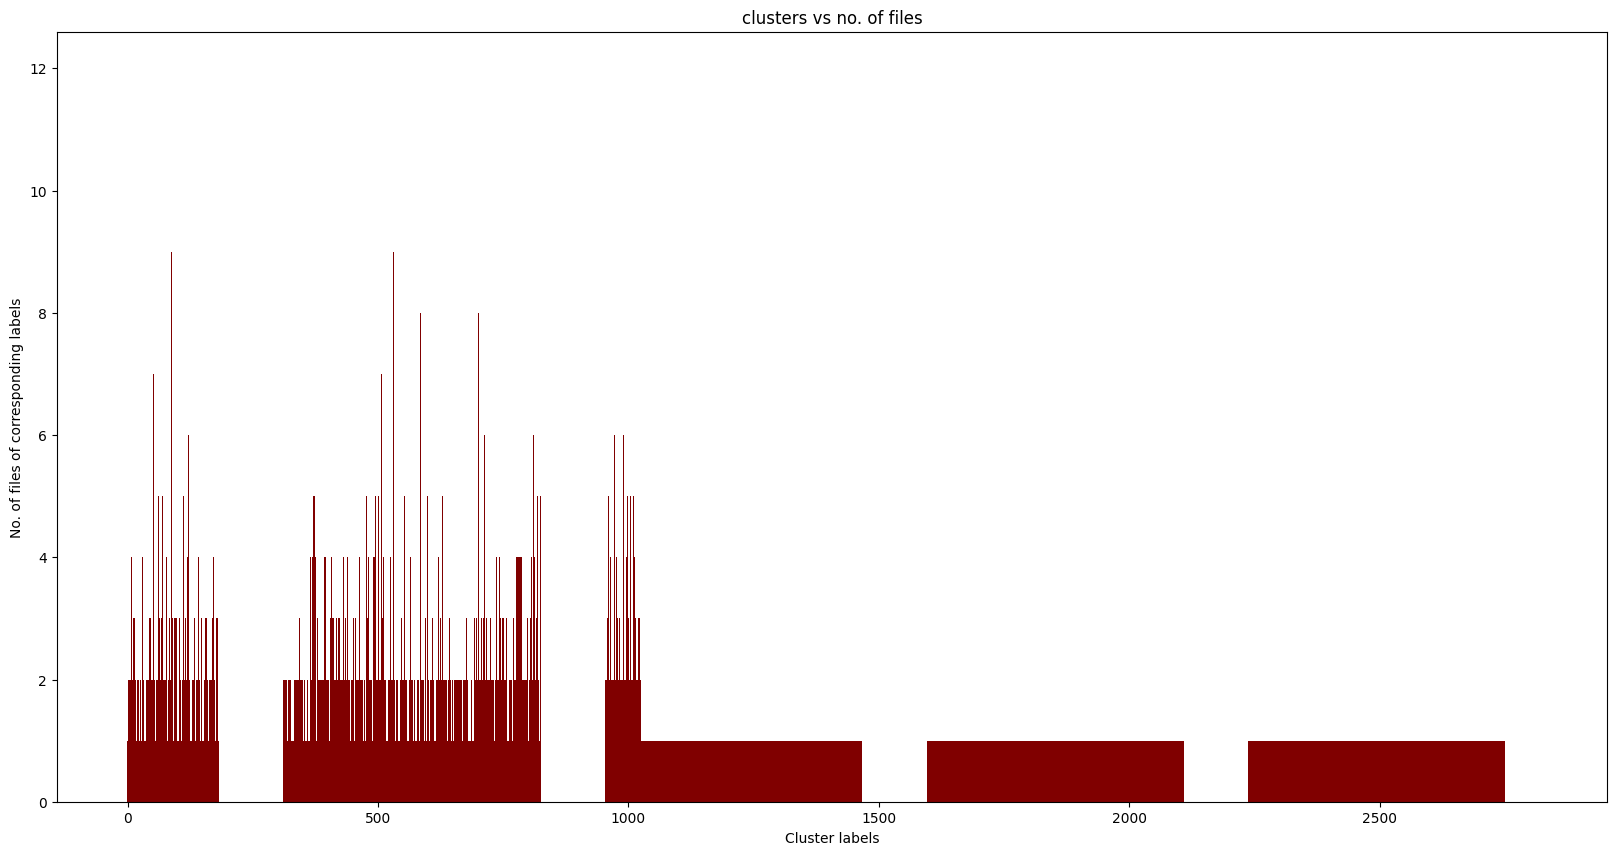

In [25]:
s1.data_distribution()

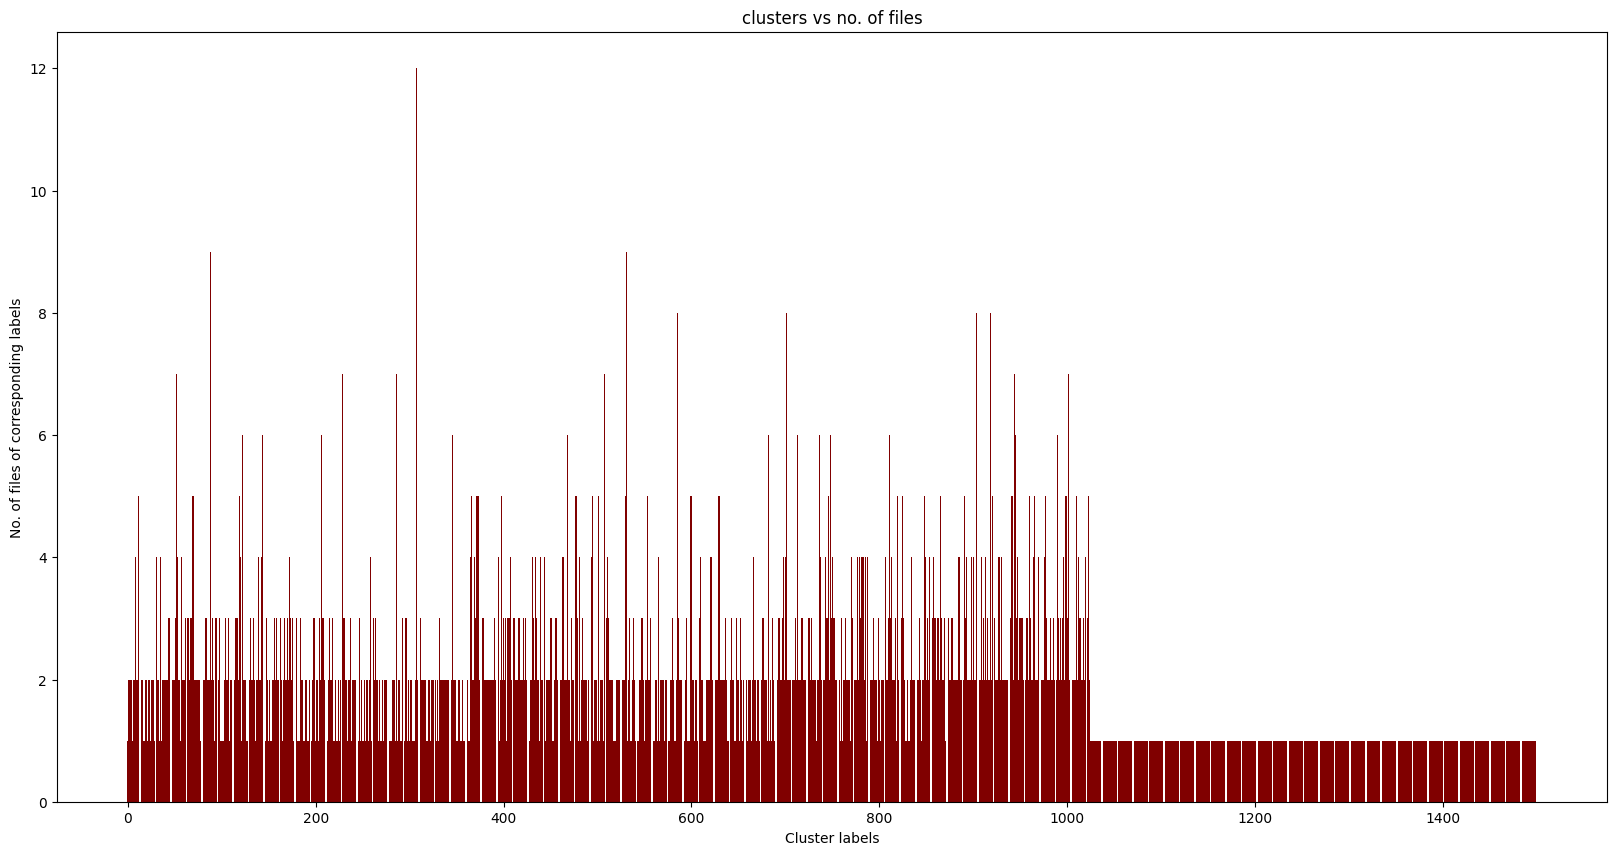

In [30]:
length = s1.maximum_cluster_label()
dictionary = {}
for i in range(length+1):
    num_files, flag = s1.db.search_cluster_label_files(i)
    if(flag):
        if(len(num_files) > 0):
            dictionary[i] = len(num_files)
    else:
        dictionary[i] = 0
    

clusters = list(dictionary.keys())
values = list(dictionary.values())

fig = plt.figure(figsize = (20, 10))

# creating the bar plot
plt.bar(clusters[:1500], values[:1500], color ='maroon', width = 0.9)

plt.xlabel("Cluster labels")
plt.ylabel("No. of files of corresponding labels")
plt.title("clusters vs no. of files")
plt.show()

In [27]:
dictionary[1500]

1

In [32]:
cluster_6_files = []
for i, ele in enumerate(values):
    if ele == 6:
        cluster_6_files.append(i)

print(cluster_6_files)

[122, 143, 206, 276, 346, 468, 682, 713, 736, 748, 811, 945, 972, 990]


In [34]:
s1.find_files(990)

[('134997_313-986d_flat1_prt.stl',),
 ('139414_313-893d_flat1_prt.stl',),
 ('142764_313-987d_flat1_prt.stl',),
 ('143510_313-734d_flat1_prt.stl',),
 ('145510_313-994d_flat1_prt.stl',),
 ('148353_313-427d_flat1_prt.stl',)]

In [6]:
class calculate_clusters:
    def __init__(self, feature_data_base, cluster_representative_folder,
                  min_cluster_size=2, min_samples=1, similarity_threshold=0.97):
        self.feature_data_base = feature_data_base
        self.cluster_representative_folder = cluster_representative_folder
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples
        self.similarity_threshold = similarity_threshold
        self.stl_files = [] 
        self.cluster_minus_one_folder = []
        self.num_stl_files = None
        self.cluster_labels = None
        self.max_cluster_label = None
        self.stl_label_feature_dict = defaultdict(dict)
        self.representative_dict = defaultdict(lambda: np.array([]))
        self.all_features = []
        self.error_files = []

    #### ------------------------------------------------------------ cluster generation ------------------------------------------------------------------####
    def extract_feature_from_database(self):
        self.num_stl_files = self.feature_data_base.count_files()
        for id_number in range(1, self.num_stl_files+1):                    # Start enumeration at 1
            stl_file, feature_file_name, flag = self.feature_data_base.find_feature_vector_through_id(id_number)
            if flag:
                feature_file_name = feature_file_name.replace("\\", "/")
                if os.path.exists(feature_file_name):
                    print(f"The directory is : {feature_file_name}")
                    feature = np.load(feature_file_name)
                    feature = np.array(feature)
                    self.all_features.append(feature)
                    self.stl_files.append(stl_file)
                    print(f"Fetched feature for {id_number} : {stl_file}")
                else:
                    self.error_files.append(stl_file)
                    print(f"The directory does not exist for {id_number}")
            else:
                if stl_file:
                    self.error_files.append(stl_file)
                    print(f"Facing error to fetch feature of for {id_number} :  {stl_file}")
                else:
                    print(f"The ID Number {id_number} does not exist in the data table")

        for file in self.error_files:
            self.feature_data_base.send_labels_to_db(file, -2)

    def generate_clusters(self):
        self.extract_feature_from_database()
        all_features = np.array(self.all_features)
        scaler = StandardScaler()
        all_features = scaler.fit_transform(all_features)

        # Perform HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=self.min_cluster_size, min_samples=self.min_samples)
        self.cluster_labels = clusterer.fit_predict(all_features)

    def move_files_to_clusters(self):      # Move files to their respective cluster folders

        for idx, label in enumerate(self.cluster_labels):
            label = int(label)
            self.stl_label_feature_dict[label][self.stl_files[idx]] = self.all_features[idx]

        self.max_cluster_label = int(np.max(self.cluster_labels))


    ###-----------------------------------------Preprocess and representative calculation-----------------------------------------------------###

    # Function to normalize a feature vector
    def normalize_vector(self, vector):
        norm = np.linalg.norm(vector)
        return vector / norm if norm > 0 else vector
    

    def calculate_medoid(self, cluster_points):
        distances = cdist(cluster_points, cluster_points, metric='euclidean')
        medoid_index = np.argmin(distances.sum(axis=1))
        return cluster_points[medoid_index]
    
        
    # Function to process files in a cluster
    def process_cluster_and_calculate_representative(self, cluster_label):
        cluster_files = list(self.stl_label_feature_dict[cluster_label].keys())
        cluster_features = []
        file_paths = []

        # Load features
        for file in cluster_files:
            feature = self.stl_label_feature_dict[cluster_label][file]      #self.feature_data_base.find_feature_vector(file)
            normalized_feature = self.normalize_vector(feature)
            cluster_features.append(normalized_feature)
            file_paths.append(file)

        if not cluster_features:
            return []

        cluster_features = np.array(cluster_features)
        medoid = self.calculate_medoid(cluster_features)
        files_to_move = set()
        for i, feature in enumerate(cluster_features):
            similarity_to_centroid = cosine_similarity([feature], [medoid])[0][0]
            if similarity_to_centroid < self.similarity_threshold:
                files_to_move.add(file_paths[i])                     # dissimilar files.

        refined_cluster_files = []
        for file in cluster_files:
            if file in files_to_move:
                continue
            self.feature_data_base.send_labels_to_db(file, cluster_label)
            refined_cluster_files.append(file)                       # refined the files which are in the cluster label.

        refined_cluster_features = []
        for file in refined_cluster_files:
            feature = self.stl_label_feature_dict[cluster_label][file]
            refined_cluster_features.append(feature)                  # Features of the files which are in the cluster label.

        if len(refined_cluster_features) >= 1:
            refined_cluster_features = np.array(refined_cluster_features)
            cluster_medoid = self.calculate_medoid(refined_cluster_features)
            self.representative_dict[cluster_label] = cluster_medoid
            print(f"Medoid is calculated for the cluster_{cluster_label}")    #calculate the representative of the cluster label.
        else:
            print(f"failed to calculate medoid for cluster_{cluster_label}")

        return list(files_to_move)
    
    # Function to move files to single cluster
    def move_files_to_single_cluster(self, cluster_label, files_to_move):
        for file in files_to_move:
            self.max_cluster_label += 1
            self.feature_data_base.send_labels_to_db(file, self.max_cluster_label)
            self.representative_dict[self.max_cluster_label] = self.stl_label_feature_dict[cluster_label][file]
            print(f"Medoid is calculated for the cluster_{self.max_cluster_label}")

    # Iterate through each cluster and process files
    def process_cluster_and_move_dissimilar_files(self):
        unique_cluster_labels = self.max_cluster_label
        for cluster_label in range(unique_cluster_labels+1):
            if cluster_label != -1:
                files_to_move = self.process_cluster_and_calculate_representative(cluster_label)
                self.move_files_to_single_cluster(cluster_label, files_to_move)


    ####------------------------------------------------------ new clusters ----------------------------------------------------------------####
    
    def create_new_clusters_for_cluster_minus_one(self):
        files_in_cluster_minus_one = list(self.stl_label_feature_dict[-1].keys())
        for file in files_in_cluster_minus_one:
            self.max_cluster_label += 1
            self.feature_data_base.send_labels_to_db(file, self.max_cluster_label)
            self.representative_dict[self.max_cluster_label] = self.stl_label_feature_dict[-1][file]
            print(f"Medoid is calculated for the cluster_{self.max_cluster_label}")

    ####------------------------------------------------------ Save cluster Representative ------------------------------------------------####

    def create_cluster_representative_folder(self):
        files_in_particular_cluster = list(self.stl_label_feature_dict[0].keys())
        particular_feature_vector = self.stl_label_feature_dict[0][files_in_particular_cluster[0]]
        vector_length = len(particular_feature_vector)
        print(vector_length)
        cluster_representatives = np.zeros((self.max_cluster_label+1, vector_length))
        for i in range(self.max_cluster_label+1):
            cluster_representatives[i] = self.representative_dict[i]

        #->->->-> put the all representative 2d vector in the s3 bucket.
        all_clusters_representative_file_name = os.path.join(self.cluster_representative_folder, f'all_clusters_representative.npy')
        np.save(all_clusters_representative_file_name, cluster_representatives)
        print(f"Complete!")


    ###------------------------------------------------------- Calculate metric -------------------------------------------------------------###

    def load_features_and_labels(self):
        all_features = []
        all_labels = []
        max_cluster_label = self.feature_data_base.maximum_cluster_label()
        for cluster_label in range(max_cluster_label+1):
            cluster_files_from_db = self.feature_data_base.find_files(cluster_label)
            cluster_files = []
            if cluster_files_from_db != None:
                for element in cluster_files_from_db:
                    cluster_files.append(element[0])
            else:
                continue

            for file in cluster_files:
                feature, flag = self.feature_data_base.find_feature_vector(file)
                if flag:
                    all_features.append(feature)
                    all_labels.append(cluster_label)
                else:
                    print(f"Feature file not found for {file}")

        return np.array(all_features), np.array(all_labels)
    
    def calculate_metrices(self):
        features, labels = self.load_features_and_labels()
        # Compute the Silhouette Score for all samples
        if len(features) > 1 and len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features, labels)
            calinski_harabasz_avg = calinski_harabasz_score(features, labels)
            davies_bouldin_avg = davies_bouldin_score(features, labels)
            print(f"Overall Silhouette Score : {silhouette_avg:.4f}")
            print(f"Overall calinski harabasz avg : {calinski_harabasz_avg:.4f}")
            print(f"Overall davies bouldin score avg : {davies_bouldin_avg:.4f}")
        else:
            print("Not enough data or clusters to compute Silhouette Score.")
        print("Processing complete.")
        

In [7]:
cluster_representative_folder = r"C:\Users\soura\Desktop\PDSV_codes\stl_5000_representative"
os.makedirs(cluster_representative_folder, exist_ok=True)
if os.path.exists(cluster_representative_folder):
    print(f"The directory is : {cluster_representative_folder}")
else:
    print(f"The directory does not exist")

The directory is : C:\Users\soura\Desktop\PDSV_codes\stl_5000_representative


In [8]:
calculate_clusters_instance = calculate_clusters(s1, cluster_representative_folder)

In [ ]:
#calculate_clusters_instance.extract_feature_from_database()

The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1013826_1-323326_prt_features.npy
Fetched feature for 1 : 1013826_1-323326_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1013858_1-643172_prt_features.npy
Fetched feature for 2 : 1013858_1-643172_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1038615_116-1054_prt_features.npy
Fetched feature for 3 : 1038615_116-1054_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1040428_0000000317p2_prt_features.npy
Fetched feature for 4 : 1040428_0000000317p2_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1040431_0000000209_prt_features.npy
Fetched feature for 5 : 1040431_0000000209_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1040433_p2_prt_features.npy

In [ ]:
#calculate_clusters_instance.error_files

['173829_105-8395_prt.stl']

In [ ]:
calculate_clusters_instance.generate_clusters()

The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1013826_1-323326_prt_features.npy
Fetched feature for 1 : 1013826_1-323326_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1013858_1-643172_prt_features.npy
Fetched feature for 2 : 1013858_1-643172_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1038615_116-1054_prt_features.npy
Fetched feature for 3 : 1038615_116-1054_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1040428_0000000317p2_prt_features.npy
Fetched feature for 4 : 1040428_0000000317p2_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1040431_0000000209_prt_features.npy
Fetched feature for 5 : 1040431_0000000209_prt.stl
The directory is : C:/Users/soura/Desktop/PDSV_codes/stl_5000_feature_folder/proj_features/1040433_p2_prt_features.npy

c:\Users\soura\anaconda3\envs\pdsv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\soura\anaconda3\envs\pdsv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
calculate_clusters_instance.move_files_to_clusters()

In [15]:
calculate_clusters_instance.max_cluster_label

1024

In [16]:
calculate_clusters_instance.process_cluster_and_move_dissimilar_files()

updatation of label is sucessfull for the 1248359_prt0001_prt.stl
Medoid is calculated for the cluster_0
updatation of label is sucessfull for the 1248455_prt002_prt.stl
Medoid is calculated for the cluster_1025
updatation of label is sucessfull for the 147408_313-001d_flat1_prt.stl
updatation of label is sucessfull for the 148090_313-450d_flat1_prt.stl
Medoid is calculated for the cluster_1
updatation of label is sucessfull for the 141315_313-481d_flat1_prt.stl
Medoid is calculated for the cluster_1026
updatation of label is sucessfull for the 1180217_401-10600-rm1_prt.stl
updatation of label is sucessfull for the 1182844_401-10600-rm2_prt.stl
Medoid is calculated for the cluster_2
updatation of label is sucessfull for the 123906_315-355d_prt.stl
updatation of label is sucessfull for the 147026_315-407d_prt.stl
Medoid is calculated for the cluster_3
updatation of label is sucessfull for the 147030_fdr3590__prt.stl
Medoid is calculated for the cluster_1027
updatation of label is sucess

In [17]:
calculate_clusters_instance.max_cluster_label

1487

In [18]:
calculate_clusters_instance.create_new_clusters_for_cluster_minus_one()

updatation of label is sucessfull for the 1040434_0000000309helx_prt.stl
Medoid is calculated for the cluster_1488
updatation of label is sucessfull for the 1040435_0000000313hole_prt.stl
Medoid is calculated for the cluster_1489
updatation of label is sucessfull for the 1040436_0000000305p_prt.stl
Medoid is calculated for the cluster_1490
updatation of label is sucessfull for the 1040439_0000000308helx_prt.stl
Medoid is calculated for the cluster_1491
updatation of label is sucessfull for the 1041040_0000000315p1_prt.stl
Medoid is calculated for the cluster_1492
updatation of label is sucessfull for the 1041074_01-201-4520_mir_prt.stl
Medoid is calculated for the cluster_1493
updatation of label is sucessfull for the 1041132_104-4993fr_mir_prt.stl
Medoid is calculated for the cluster_1494
updatation of label is sucessfull for the 1041315_103-2616-a_mir_prt.stl
Medoid is calculated for the cluster_1495
updatation of label is sucessfull for the 1041506_104-4836fr_mir_prt.stl
Medoid is c

In [19]:
calculate_clusters_instance.max_cluster_label

2813

In [20]:
calculate_clusters_instance.create_cluster_representative_folder()

5120
Complete!


In [21]:
aws_all_representative_path = os.path.join(cluster_representative_folder, f'all_clusters_representative.npy')
vectors1 = None
if os.path.exists(aws_all_representative_path):
    a_representative = np.load(aws_all_representative_path)
    vectors1 = np.array(a_representative)

In [22]:
vectors1.shape

(2814, 5120)

# Temporary variables

In [79]:
c_labels = calculate_clusters_instance.cluster_labels
print(type(c_labels))
print(c_labels.shape)
print(c_labels)

<class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'shape'

In [63]:
s_files = calculate_clusters_instance.stl_files
print(type(s_files))
print(len(s_files))
print(s_files)

<class 'list'>
4265
['1013826_1-323326_prt.stl', '1013858_1-643172_prt.stl', '1038615_116-1054_prt.stl', '1040428_0000000317p2_prt.stl', '1040431_0000000209_prt.stl', '1040433_p2_prt.stl', '1040434_0000000309helx_prt.stl', '1040435_0000000313hole_prt.stl', '1040436_0000000305p_prt.stl', '1040437_0000000306p1_prt.stl', '1040439_0000000308helx_prt.stl', '1040440_0000000312_prt.stl', '1040777_130-4534_prt.stl', '1040867_353-781fr_prt.stl', '1041040_0000000315p1_prt.stl', '1041074_01-201-4520_mir_prt.stl', '1041132_104-4993fr_mir_prt.stl', '1041202_237-80_mir_prt.stl', '1041235_01-201-3290fr_mir_prt.stl', '1041315_103-2616-a_mir_prt.stl', '1041354_0000000348_prt.stl', '1041400_237-42_mir_prt.stl', '1041401_1-513840fr_mir_prt.stl', '1041506_104-4836fr_mir_prt.stl', '1041594_0000000127_prt.stl', '1041595_0000000123_prt.stl', '1041596_0000000128_prt.stl', '1041597_0000000126_prt.stl', '1045086_100-9634fr_prt.stl', '1045305_0000000357_prt.stl', '1131335_1180-1530_prt.stl', '1131337_191-12933_p

In [64]:
stl_all_features = calculate_clusters_instance.all_features
print(type(stl_all_features))
print(stl_all_features[0].shape)
print(stl_all_features[0])

<class 'list'>
(5120,)
[0.        0.        0.8500222 ... 0.        0.        0.       ]


In [85]:
calculate_clusters_instance.all_features = stl_all_features

In [86]:
calculate_clusters_instance.stl_files = s_files

In [70]:
calculate_clusters_instance.cluster_labels = c_labels